# Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
 
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |
 
Each video is a sequence of 30 frames (or images).
 
### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
 
2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.
 
3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import random as rn
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import inception_v3, mobilenet
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
rn.seed(30)

#### Set basic parameters
- Path of datasets

In [3]:
# Specify training and validation documents
train_doc = np.random.permutation(open('./Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/Project_data/val.csv').readlines())

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Specify training and validation path
train_path = './Project_data/Project_data/train'
val_path = './Project_data/Project_data/val'

# training sequences = 663
# validation sequences = 100


- Path of model file

In [4]:
# Create a directory and filepath to save the best model
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

- Image properties

In [5]:
image_height = 100
image_width = 100
channel = 3

- Number of classification classes

In [6]:
num_classes = 5

In [7]:
# Method to generate image tensor with n_frames
def getImgTensor(n_frames,image_height=image_height,image_width=image_width,channel=channel):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    img_tensor = [img_idx, image_height, image_width, channel]
    return img_tensor

In [8]:
# Method for calculation number of steps per epoch and validation steps
def calculate_steps(batch_size, num_train_sequences=num_train_sequences, num_val_sequences=num_val_sequences, ablation=None):
    #ablation=25
    if (ablation != None):
        num_train_sequences = ablation
        num_val_sequences = ablation

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    print("steps_per_epoch",steps_per_epoch)

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print("validation_steps",validation_steps)

    return steps_per_epoch, validation_steps

In [9]:
# Method to plot Loss and Accuracy for train and validation data set
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

#### Generator

In [10]:
def getImages(source_path,batch_size,batch,img_tensor,t,remaing_size=0):
    x = len(img_tensor[0])
    y = img_tensor[1]
    z = img_tensor[2]

    img_idx = img_tensor[0]

    size = remaing_size if remaing_size else batch_size

    # x is the number of images you use for each video
    # (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_data = np.zeros((size,x,y,z,3)) 

    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((size,5)) 

    # Iterate over the batch_size
    for folder in range(size):

        # Read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])

        #  Iterate over the frames/images of a folder to read them in
        for idx,item in enumerate(img_idx): 
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
            
            # Normalize the image
            image = image.astype('float32')
            image = image/255
            
            # # Crop bigger images to 120 X 120
            # if(image.shape[1] == 160):
            #     image = image[:120, 20:140]

            # Resize the image to 100 X 100
            if(image.shape[0]!= y & image.shape[1]!=z):
                image = resize(image,(y,z))   

            # Feed in the image          
            batch_data[folder,idx,] = image 

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels


In [11]:
def generator(source_path, folder_list, batch_size, img_tensor, ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        # If ablation is true then reduce the folder size to sample size
        #ablation = 25
        if(ablation!=None):
          folder_list = folder_list[:ablation]
          
        t = np.random.permutation(folder_list)

        # calculate the number of batches
        num_batches = len(folder_list)//batch_size 
        
        # Iterate over the number of batches
        for batch in range(num_batches):             
            batch_data, batch_labels = getImages(source_path,batch_size,batch,img_tensor,t)
            #you yield the batch_data and the batch_labels
            yield batch_data, batch_labels
        
        # write the code for the remaining data points which are left after full batches
        if(len(folder_list) % batch_size != 0):
            remaing_size = len(folder_list) % batch_size
            batch_data, batch_labels = getImages(source_path,batch_size,num_batches,img_tensor,t,remaing_size)
            yield batch_data, batch_labels


#### Validate Generator

Source path =  ./Project_data/Project_data/train ; batch size = 10
(10, 16, 100, 100, 3)
(10, 5)
(2, 16, 100, 100, 3)
(2, 5)


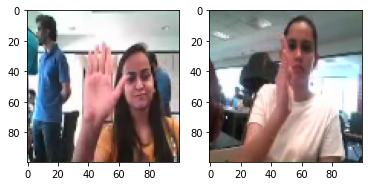

In [12]:
img_tensor = getImgTensor(16)
test_batch_size = 10
sample_generator = generator(train_path, train_doc, test_batch_size, img_tensor, ablation=12)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)
print(sample_batch_labels.shape)

sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)
print(sample_batch_labels.shape)

# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[0,10,:,:,:])   
ax[1].imshow(sample_batch_data[1,10,:,:,:])
plt.show()

#### Running Ablation Experiments

Base Model
- 3 conv3D Layers
- Frames: 16

In [13]:
def baseModel():
    # Set Hyperparameters
    n_frames = 16

    img_tensor = getImgTensor(n_frames)
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    # Build model
    model= Sequential()

    model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))

    model.add(Dense(64,activation="relu"))

    model.add(Dense(num_classes,activation="Softmax"))

    # Compile model and print summary
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

model = baseModel()
print(" Model Summary ".center(65,"="))
print (model.summary())

========================= Model Summary =========================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 25, 25, 64)     55360     
                                                        

2023-06-17 13:02:28.928957: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 13:02:28.929023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Checking that the model is 'working'

========================== No of Steps ==========================
steps_per_epoch 3
validation_steps 3


======================== Model Execution ========================
Source path =  ./datasets/Project_data/train ; batch size = 10
Epoch 1/4


2023-06-17 13:02:48.729880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


3/3 [==============================] - 8s 3s/step - loss: 1.7035 - categorical_accuracy: 0.2800 - val_loss: 1.7738 - val_categorical_accuracy: 0.2400
Epoch 2/4
3/3 [==============================] - 6s 3s/step - loss: 1.6108 - categorical_accuracy: 0.2400 - val_loss: 1.6427 - val_categorical_accuracy: 0.1600
Epoch 3/4
3/3 [==============================] - 6s 3s/step - loss: 1.5530 - categorical_accuracy: 0.4400 - val_loss: 1.7356 - val_categorical_accuracy: 0.2000
Epoch 4/4
3/3 [==============================] - 6s 3s/step - loss: 1.5683 - categorical_accuracy: 0.2400 - val_loss: 1.6600 - val_categorical_accuracy: 0.2000


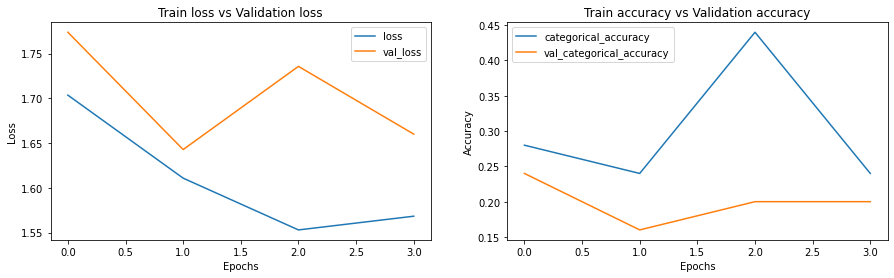

Max. Training Accuracy 0.4399999976158142
Max. Validaiton Accuracy 0.23999999463558197


In [14]:
# Set Hyperparameters
batch_size = 10
num_epochs = 4
ablation = 25

# Build base model
model = baseModel()

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor, ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, ablation=ablation)

# Calculate steps per epoch and validation steps
print(" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    class_weight=None, workers=1, initial_epoch=0)
                    
# Plot Loss and Accuracy
plotModelHistory(results)

Overfitting on the Training Data

========================== No of Steps ==========================
steps_per_epoch 3
validation_steps 3


======================== Model Execution ========================
Source path =  ./datasets/Project_data/train ; batch size = 10
Epoch 1/15
3/3 [==============================] - 7s 3s/step - loss: 1.6393 - categorical_accuracy: 0.2400 - val_loss: 1.6028 - val_categorical_accuracy: 0.3200
Epoch 2/15
3/3 [==============================] - 6s 3s/step - loss: 1.5336 - categorical_accuracy: 0.4800 - val_loss: 1.7124 - val_categorical_accuracy: 0.2400
Epoch 3/15
3/3 [==============================] - 6s 3s/step - loss: 1.5136 - categorical_accuracy: 0.2400 - val_loss: 1.7084 - val_categorical_accuracy: 0.2800
Epoch 4/15
3/3 [==============================] - 6s 3s/step - loss: 1.4053 - categorical_accuracy: 0.2400 - val_loss: 1.6411 - val_categorical_accuracy: 0.2800
Epoch 5/15
3/3 [==============================] - 6s 3s/step - loss: 1.2086 - categorical_accuracy: 0.5600 - val_loss: 1.8

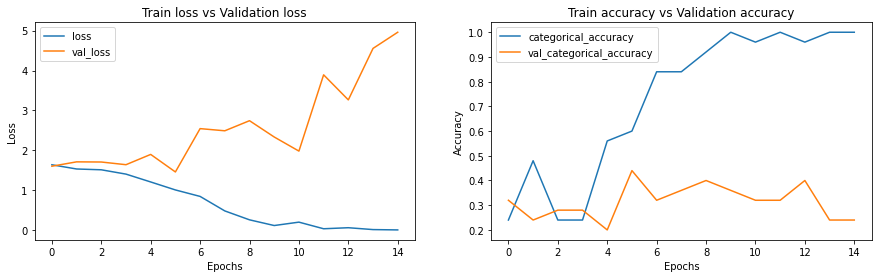

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.4399999976158142


In [16]:
# Set Hyperparameters
batch_size = 10
num_epochs = 15
ablation = 25

# Build base model
model = baseModel()

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor, ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, ablation=ablation)

# Calculate steps per epoch and validation steps
print(" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    class_weight=None, workers=1, initial_epoch=0)
                    
# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 1
- 3 conv3D Layers with dropouts
- Frames: 16
- Batch : 16
- Epochs: 20
- Accuracy: 0.85, Val_accuracy: 0.87

========================= Model Summary =========================
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 4, 25, 25, 32)     0         
                                                      

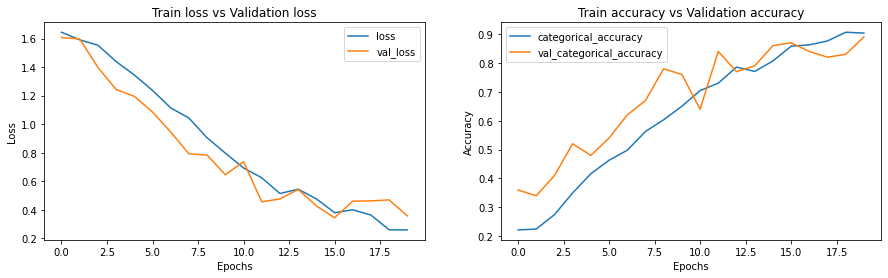

Max. Training Accuracy 0.9064856767654419
Max. Validaiton Accuracy 0.8899999856948853


In [16]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 2
- 3 conv3D Layers with dropouts
- Frames: 16
- Batch : 16
- Epochs: 20
- Optimizer : SGD
- Accuracy: 0.52, Val_accuracy: 0.61

========================= Model Summary =========================
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 25, 25, 32)     0         
                                                      

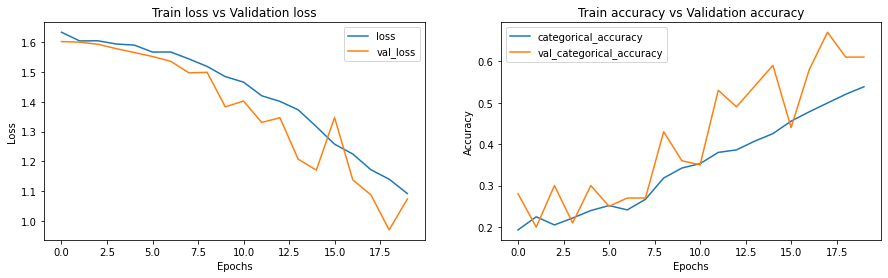

Max. Training Accuracy 0.5384615659713745
Max. Validaiton Accuracy 0.6700000166893005


In [17]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)                    

#### Model 3
- 4 conv3D Layers with dropouts
- Frames: 16
- Batch : 16
- Epochs: 20
- Accuracy: 0.79, Val_accuracy: 0.88

========================= Model Summary =========================
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 4, 25, 25, 32)     0         
                                                      

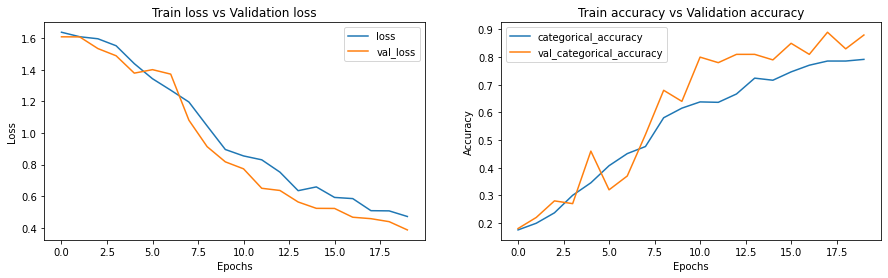

Max. Training Accuracy 0.7918552160263062
Max. Validaiton Accuracy 0.8899999856948853


In [17]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 4
- 4 conv3D Layers with each layer repeated twice and dropouts
- Frames: 16
- Batch : 16
- Epochs: 20
- Accuracy: 0.19, Val_accuracy: 0.23

========================= Model Summary =========================
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 100, 100, 16)  6928      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 conv3d_19 (Conv3D)          (None, 8, 50, 50, 32)     27680     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 25, 25, 32)   

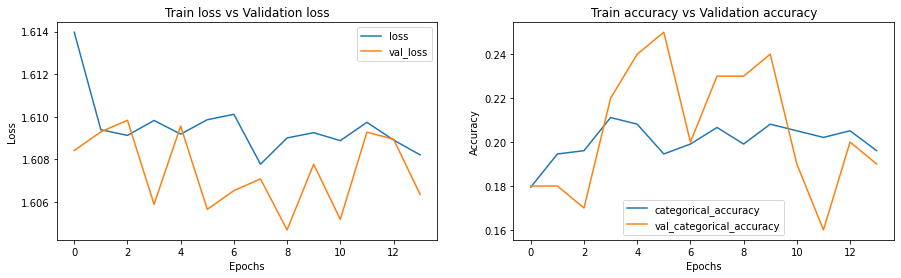

Max. Training Accuracy 0.21116138994693756
Max. Validaiton Accuracy 0.25


In [18]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)                    

#### Model 5
- 4 conv3D Layers with dropouts
- Frames: 16
- Batch : 16
- Epochs: 20
- Learning Rate: 0.002
- Accuracy: 0.83, Val_accuracy:0.844

========================= Model Summary =========================
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 4, 25, 25, 32)     0         
                                                      

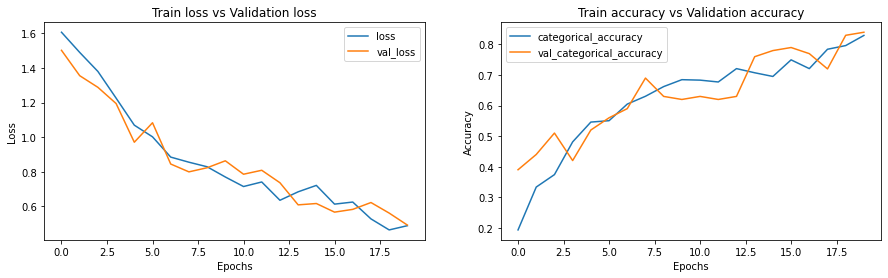

Max. Training Accuracy 0.8295626044273376
Max. Validaiton Accuracy 0.8399999737739563


In [19]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)                    

#### Model 6
- 4 conv3D Layers with dropouts and BatchNormalization 
- Frames: 16
- Batch : 16
- Epochs: 20
- Accuracy: 0.24, Val_accuracy: 0.32

========================= Model Summary =========================
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_31 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_32 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 50, 50, 32)    128       
 hNormalization)                                      

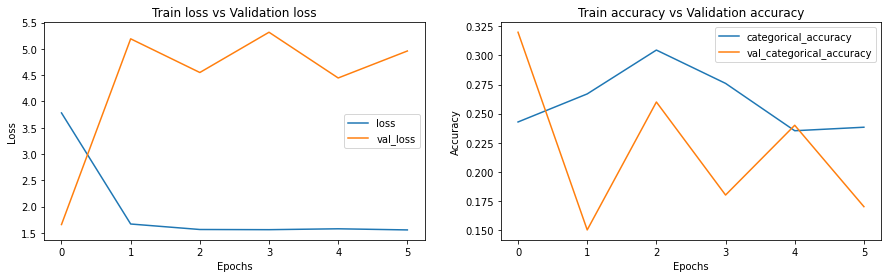

Max. Training Accuracy 0.30467572808265686
Max. Validaiton Accuracy 0.3199999928474426


In [21]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 20
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 7
- 4 conv3D Layers with dropouts
- Frames: 16
- Batch : 16
- Epochs: 30
- Accuracy: 0.91, Val_accuracy:0.90

========================= Model Summary =========================
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 4, 25, 25, 32)     0         
                                                      

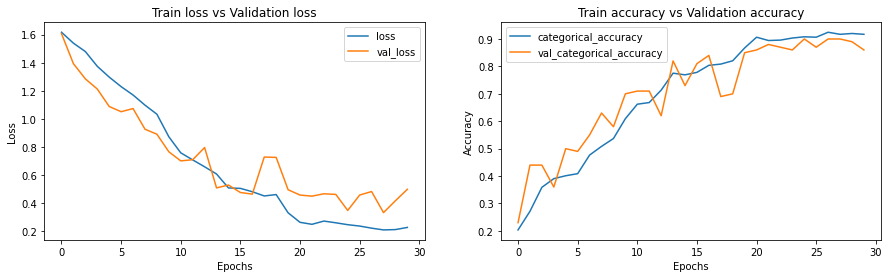

Max. Training Accuracy 0.924585223197937
Max. Validaiton Accuracy 0.8999999761581421


In [21]:
# Set Hyperparameters
n_frames = 16
batch_size = 16
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)   

#### Model 8
- 4 conv3D Layers with dropouts
- Frames: 16
- Batch : 32
- Epochs: 30
- Accuracy: 0.89, Val_accuracy: 0.93

========================= Model Summary =========================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 25, 25, 32)     0         
                                                        

2023-06-17 17:06:18.858332: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 17:06:18.858411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5




======================== Model Execution ========================
Source path =  ./datasets/Project_data/train ; batch size = 32
Epoch 1/30


2023-06-17 17:06:23.978756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6124 - categorical_accuracy: 0.2247Source path =  ./datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60309, saving model to model_init_2023-06-1717_03_09.472164/model-00001-1.61239-0.22474-1.60309-0.18000.h5
21/21 [==============================] - 84s 4s/step - loss: 1.6124 - categorical_accuracy: 0.2247 - val_loss: 1.6031 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5788 - categorical_accuracy: 0.2293
Epoch 00002: val_loss improved from 1.60309 to 1.42796, saving model to model_init_2023-06-1717_03_09.472164/model-00002-1.57877-0.22926-1.42796-0.19000.h5
21/21 [==============================] - 83s 4s/step - loss: 1.5788 - categorical_accuracy: 0.2293 - val_loss: 1.4280 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4840 - categorical_accuracy:

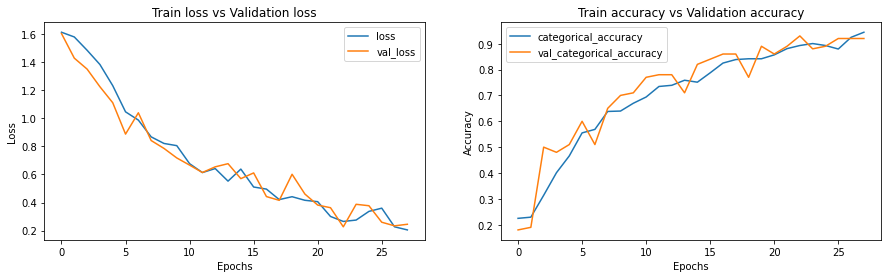

Max. Training Accuracy 0.9441930651664734
Max. Validaiton Accuracy 0.9300000071525574


In [13]:
# Set Hyperparameters
n_frames = 16
batch_size = 32
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 9
- 4 conv3D Layers with dropouts
- Frames: 16
- Batch : 64
- Epochs: 30
- Accuracy: 0.87, Val_accuracy: 0.90

========================= Model Summary =========================
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 4, 25, 25, 32)     0         
                                                      

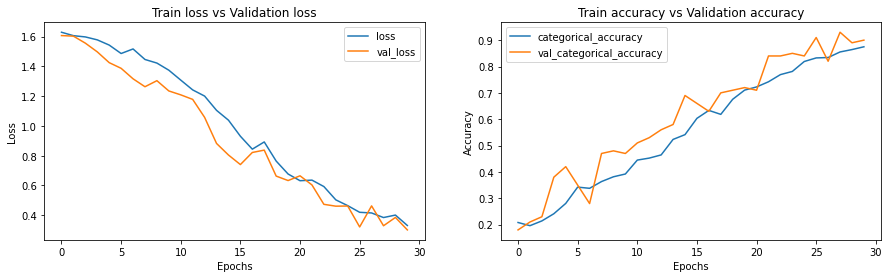

Max. Training Accuracy 0.8748114705085754
Max. Validaiton Accuracy 0.9300000071525574


In [18]:
# Set Hyperparameters
n_frames = 16
batch_size = 64
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print()
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print()
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)

#### Model 10
- 4 conv3D Layers with dropouts
- Frames: 20
- Batch : 16
- Epochs: 30
- Accuracy: 0.86, Val_accuracy: 0.85

========================= Model Summary =========================
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 5, 25, 25, 32)     0         
                                                      

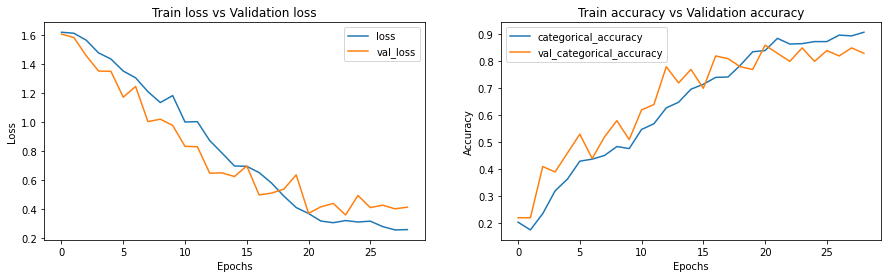

Max. Training Accuracy 0.9079939723014832
Max. Validaiton Accuracy 0.8600000143051147


In [19]:
# Set Hyperparameters
n_frames = 20
batch_size = 16
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)   

#### Model 11
- 4 conv3D Layers with dropouts
- Frames: 25
- Batch : 16
- Epochs: 30
- Accuracy: 0.87, Val_accuracy: 0.89

========================= Model Summary =========================
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 25, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 12, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 6, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 6, 25, 25, 32)     0         
                                                      

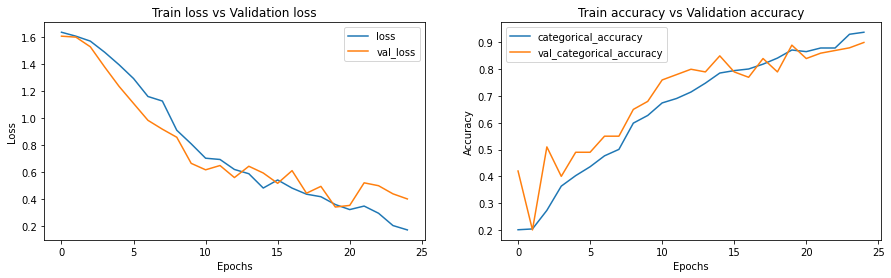

Max. Training Accuracy 0.9381598830223083
Max. Validaiton Accuracy 0.8999999761581421


In [14]:
# Set Hyperparameters
n_frames = 25
batch_size = 16
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)   

#### Model 12
- 4 conv3D Layers with dropouts
- Frames: 25
- Batch : 40
- Epochs: 30
- Accuracy: 0.93, Val_accuracy: 0.92

========================= Model Summary =========================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 25, 100, 100, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 50, 50, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 25, 25, 32)     0         
                                                        

2023-06-18 05:28:48.787763: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-18 05:28:48.787829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3d:00.0, compute capability: 7.5




======================== Model Execution ========================
Source path =  ./datasets/Project_data/train ; batch size = 40
Epoch 1/30


2023-06-18 05:28:56.567083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.6302 - categorical_accuracy: 0.2036Source path =  ./datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.60731, saving model to model_init_2023-06-1805_28_12.984399/model-00001-1.63018-0.20362-1.60731-0.18000.h5
17/17 [==============================] - 130s 8s/step - loss: 1.6302 - categorical_accuracy: 0.2036 - val_loss: 1.6073 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.2157
Epoch 00002: val_loss improved from 1.60731 to 1.59851, saving model to model_init_2023-06-1805_28_12.984399/model-00002-1.60962-0.21569-1.59851-0.21000.h5
17/17 [==============================] - 129s 8s/step - loss: 1.6096 - categorical_accuracy: 0.2157 - val_loss: 1.5985 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.5788 - categorical_accurac

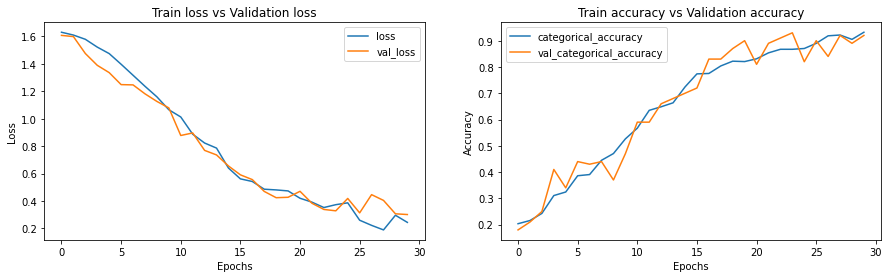

Max. Training Accuracy 0.9321267008781433
Max. Validaiton Accuracy 0.9300000071525574


In [13]:
# Set Hyperparameters
n_frames = 25
batch_size = 40
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

# Build model
model= Sequential()

model.add(Conv3D(16,kernel_size= (3,3,3),padding="same",input_shape=inputShape,activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128,kernel_size= (3,3,3),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation="Softmax"))

# Compile model and print summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(" Model Summary ".center(65,"="))
print (model.summary())

# Create test and validate generators
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

# Calculate steps per epoch and validation steps
print("\n\n"+" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size)

# Create callbacks
earlyStopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]

# Execute the model
print("\n\n"+" Model Execution ".center(65,"="))
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(results)   

#### Model 13
- LSTM with Conv2D
- Frames: 20
- Batch : 32
- Epochs: 30
- Accuracy: 0.91, Val_accuracy: 0.75

(20, 100, 100, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 25, 25, 32)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 

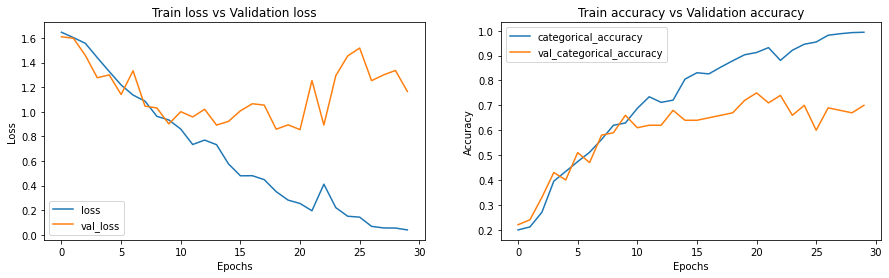

Max. Training Accuracy 0.993966817855835
Max. Validaiton Accuracy 0.75


In [16]:
n_frames = 20
batch_size = 32
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

print(inputShape)

conv2dLstmModel = Sequential()
conv2dLstmModel.add(TimeDistributed(Conv2D(16,kernel_size= (3,3),padding="same",activation="relu"),input_shape=inputShape))
conv2dLstmModel.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

conv2dLstmModel.add(TimeDistributed(Conv2D(32,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel.add(Dropout(0.25))

conv2dLstmModel.add(TimeDistributed(Conv2D(64,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel.add(Dropout(0.25))

conv2dLstmModel.add(TimeDistributed(Conv2D(128,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel.add(Dropout(0.25))


conv2dLstmModel.add(TimeDistributed(Flatten()))
conv2dLstmModel.add(LSTM(128))
conv2dLstmModel.add(Dropout(0.5))

conv2dLstmModel.add(Dense(128,activation="relu"))
conv2dLstmModel.add(Dropout(0.5))

conv2dLstmModel.add(Dense(num_classes,activation="Softmax"))


# Compile model and print summary
conv2dLstmModel.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv2dLstmModel.summary())


train_generator = generator(train_path, train_doc, batch_size, img_tensor,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor,ablation=ablation)

# Calculate steps per epoch and validation steps
print(" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Create callbacks
earlyStopping = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]


conv2dLstmModel_history = conv2dLstmModel.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


# Plot Loss and Accuracy
plotModelHistory(conv2dLstmModel_history)

#### Model 14
- LSTM with Conv2D
- Frames: 20
- Batch : 10
- Epochs: 30
- Accuracy: 0.60, Val_accuracy: 0.70

(20, 100, 100, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 20, 100, 100, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 20, 25, 25, 32)   0         
 stributed)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 

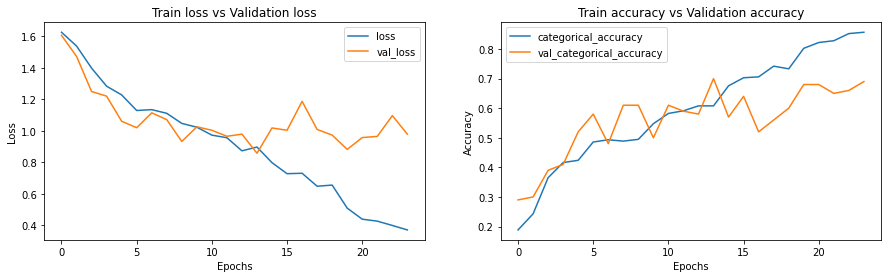

Max. Training Accuracy 0.8567119240760803
Max. Validaiton Accuracy 0.699999988079071


In [17]:
n_frames = 20
batch_size = 10
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

print(inputShape)

conv2dLstmModel2 = Sequential()
conv2dLstmModel2.add(TimeDistributed(Conv2D(16,kernel_size= (3,3),padding="same",activation="relu"),input_shape=inputShape))
conv2dLstmModel2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

conv2dLstmModel2.add(TimeDistributed(Conv2D(32,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel2.add(Dropout(0.25))

conv2dLstmModel2.add(TimeDistributed(Conv2D(64,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel2.add(Dropout(0.25))

conv2dLstmModel2.add(TimeDistributed(Conv2D(128,kernel_size= (3,3),padding="same",activation="relu")))
conv2dLstmModel2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
conv2dLstmModel2.add(Dropout(0.25))


conv2dLstmModel2.add(TimeDistributed(Flatten()))
conv2dLstmModel2.add(LSTM(128))
conv2dLstmModel2.add(Dropout(0.5))

conv2dLstmModel2.add(Dense(128,activation="relu"))
conv2dLstmModel2.add(Dropout(0.5))

conv2dLstmModel2.add(Dense(num_classes,activation="Softmax"))


# Compile model and print summary
conv2dLstmModel2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv2dLstmModel2.summary())


train_generator = generator(train_path, train_doc, batch_size, img_tensor,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor,ablation=ablation)

# Calculate steps per epoch and validation steps
print(" No of Steps ".center(65,"="))
steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Create callbacks
earlyStopping = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]


conv2dLstmModel2_history = conv2dLstmModel2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


# Plot Loss and Accuracy
plotModelHistory(conv2dLstmModel2_history)

#### Model 15
- LSTM with Transfer Learning(Inception V3)
- Frames: 20
- Batch : 32
- Epochs: 30
- Accuracy: 0.74, Val_accuracy: 0.57

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 2048)   21802784  
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 20, 1, 1, 2048)    0         
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)               1114624   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

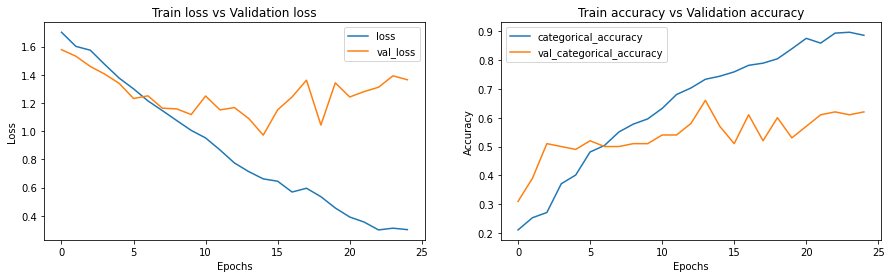

Max. Training Accuracy 0.8959276080131531
Max. Validaiton Accuracy 0.6600000262260437


In [18]:
n_frames = 20
batch_size = 32
num_epochs = 30
ablation = None

img_tensor = getImgTensor(n_frames)
inceptionInputShape = (img_tensor[1], img_tensor[2], img_tensor[3])
inceptionv3 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=inceptionInputShape)


inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

inceptionV3Model = Sequential([
    TimeDistributed(inceptionv3, input_shape=inputShape)
])

for layer in inceptionV3Model.layers:
    layer.trainable = False

inceptionV3Model.add(Dropout(0.5))
inceptionV3Model.add(TimeDistributed(Flatten()))

inceptionV3Model.add(LSTM(128))
inceptionV3Model.add(Dropout(0.5))

inceptionV3Model.add(Dense(128,activation='relu'))
inceptionV3Model.add(Dropout(0.5))

inceptionV3Model.add(Dense(num_classes, activation='Softmax'))

inceptionV3Model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(inceptionV3Model.summary())

train_generator = generator(train_path, train_doc, batch_size, img_tensor,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor,ablation=ablation)


steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Create callbacks
earlyStopping = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]


inceptionV3Model_history = inceptionV3Model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(inceptionV3Model_history)


#### Model 16
- LSTM with Transfer Learning(Mobilenet)
- Frames: 20
- Batch : 20
- Epochs: 30
- Accuracy: 0.88, Val_accuracy: 0.75

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)               590336    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                      

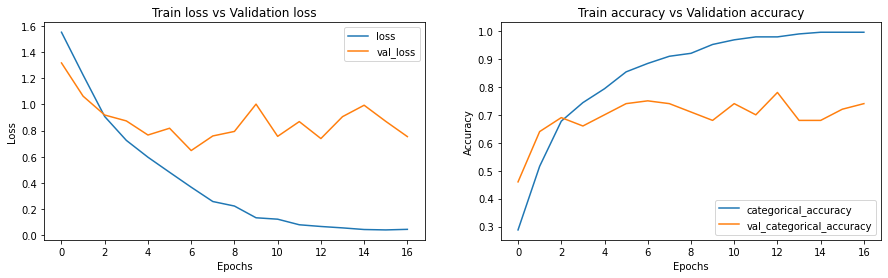

Max. Training Accuracy 0.9954751133918762
Max. Validaiton Accuracy 0.7799999713897705


In [26]:
n_frames = 20
batch_size = 20
num_epochs = 30
ablation = None


mobilenetBaseModel = mobilenet.MobileNet(weights='imagenet', include_top=False)
img_tensor = getImgTensor(n_frames)

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

mobilenetModel = Sequential([
    TimeDistributed(mobilenetBaseModel, input_shape=inputShape)
])

for layer in mobilenetModel.layers:
    layer.trainable = False

mobilenetModel.add(TimeDistributed(MaxPooling2D((2,2))))
mobilenetModel.add(TimeDistributed(Flatten()))

mobilenetModel.add(LSTM(128))
mobilenetModel.add(Dropout(0.25))

mobilenetModel.add(Dense(128,activation='relu'))
mobilenetModel.add(Dropout(0.25))

mobilenetModel.add(Dense(num_classes, activation='Softmax'))

mobilenetModel.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(mobilenetModel.summary())

train_generator = generator(train_path, train_doc, batch_size, img_tensor,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size, img_tensor,ablation=ablation)


steps_per_epoch, validation_steps = calculate_steps(batch_size, ablation=ablation)

# Create callbacks
earlyStopping = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR =ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, LR, earlyStopping]


mobilenetModel_history = mobilenetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Plot Loss and Accuracy
plotModelHistory(mobilenetModel_history)

### Predict using the best model

In [17]:
# Load the best model
model = load_model('./model-00030-0.24411-0.93213-0.30133-0.92000.h5')

In [18]:
# Generate one batch of images from validation data set
n_frames = 25
batch_size = 40
img_tensor = getImgTensor(n_frames, image_height=100, image_width=100, channel=3)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
batch_data, batch_labels=next(val_generator)
# Convert batch_labels one-hot-encoding to actual labels
labels = np.where(batch_labels)[1]
# Create a dataframe for batch labels
actual_class = pd.DataFrame(batch_labels, columns=['Class 0','Class 1','Class 2','Class 3','Class 4']).astype('int')
# Create a dataframe for actual labels
actual_labes = pd.DataFrame(labels, columns=['Actual Class'])
# Concatinate both the dataframes
actual_class = pd.concat([actual_class, actual_labes], axis=1)
print(actual_class)

Source path =  ./Project_data/Project_data/val ; batch size = 40
    Class 0  Class 1  Class 2  Class 3  Class 4  Actual Class
0         0        0        1        0        0             2
1         0        0        1        0        0             2
2         0        1        0        0        0             1
3         0        1        0        0        0             1
4         0        0        0        0        1             4
5         0        0        1        0        0             2
6         0        0        0        0        1             4
7         0        0        0        1        0             3
8         0        0        1        0        0             2
9         0        0        1        0        0             2
10        0        0        1        0        0             2
11        0        1        0        0        0             1
12        0        1        0        0        0             1
13        0        0        1        0        0             2
14   

In [19]:
# Predict the class using the best model
predicted_labels = np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)
predicted_class = pd.DataFrame(predicted_labels, columns=['Predicted Class'])
print(predicted_class)

2/2 [==============================] - 3s 511ms/step
    Predicted Class
0                 2
1                 2
2                 1
3                 1
4                 4
5                 2
6                 3
7                 3
8                 2
9                 3
10                2
11                1
12                1
13                2
14                1
15                3
16                4
17                0
18                1
19                1
20                2
21                3
22                4
23                0
24                1
25                3
26                2
27                0
28                4
29                4
30                1
31                1
32                0
33                0
34                1
35                3
36                3
37                0
38                3
39                3


In [20]:
# Compare Actual Class and Predicted Class
pd.concat([actual_class,predicted_class], axis=1)

,Class 0,Class 1,Class 2,Class 3,Class 4,Actual Class,Predicted Class
0,0,0,1,0,0,2,2
1,0,0,1,0,0,2,2
2,0,1,0,0,0,1,1
3,0,1,0,0,0,1,1
4,0,0,0,0,1,4,4
5,0,0,1,0,0,2,2
6,0,0,0,0,1,4,3
7,0,0,0,1,0,3,3
8,0,0,1,0,0,2,2
9,0,0,1,0,0,2,3
